# UK Road Safety: Supervised Learning Project
This notebook predicts accident severity (Slight, Serious, Fatal) using UK Road Safety Data (STATS19) from data.gov.uk.  
We load, merge, and preprocess data from Accidents, Casualties, and Vehicles datasets, then train multiple for multi-class classification.

Target = 'Collision_severity'
1 = Slight: Minor injuries, not life-threatening (e.g., bruises, sprains).
2 = Serious: More severe injuries, but not fatal (e.g., fractures, hospital admission).
3 = Fatal: At least one person died as a result of the accident.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import requests
import zipfile
import io
import warnings
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')  # Ignore warnings to keep the output clean.

## Load Data
Last 5 years of Accidents, Casualties, and Vehicles data from CSV URLs.

In [ ]:
# Download and load the Accidents dataset
accidents_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv"
accidents_df = pd.read_csv(io.StringIO(requests.get(accidents_url).text), low_memory=False)

# Download and load the Casualties dataset
casualties_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-last-5-years.csv"
casualties_df = pd.read_csv(io.StringIO(requests.get(casualties_url).text), low_memory=False)

# Download and load the Vehicles dataset
vehicles_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-vehicle-last-5-years.csv"
vehicles_df = pd.read_csv(io.StringIO(requests.get(vehicles_url).text), low_memory=False)

# Merge all datasets using the 'collision_index' column
df = accidents_df.merge(casualties_df, on='collision_index', how='left', suffixes=('', '_cas'))
df = df.merge(vehicles_df, on='collision_index', how='left', suffixes=('', '_veh'))

# Free up memory by deleting the original dataframes
del accidents_df, casualties_df, vehicles_df
import gc
gc.collect()

3172

## Exploratory Data Analysis (EDA)
Explore the distribution of the target variable and key features to understand class balance and data characteristics.

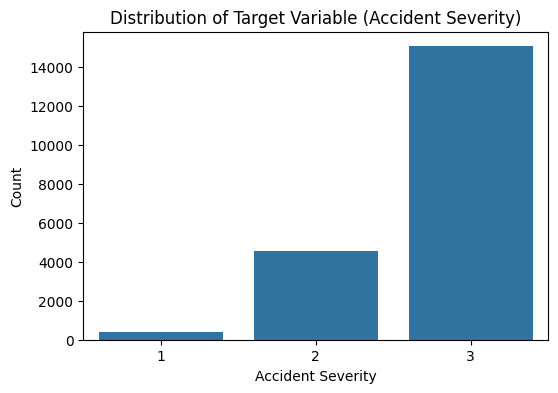

collision_severity
3    15050
2     4536
1      414
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of accident severity in the dataset
plt.figure(figsize=(6,4))
sns.countplot(x='collision_severity', data=df)
plt.title('Distribution of Target Variable (Accident Severity)')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()

# Print the count of each severity class
print(df['collision_severity'].value_counts())

collision_severity,1,2,3
year,,,
2020.0,33,271,1046
2021.0,32,307,1183
2022.0,39,357,1249
2023.0,28,380,1202
2024.0,26,431,1162


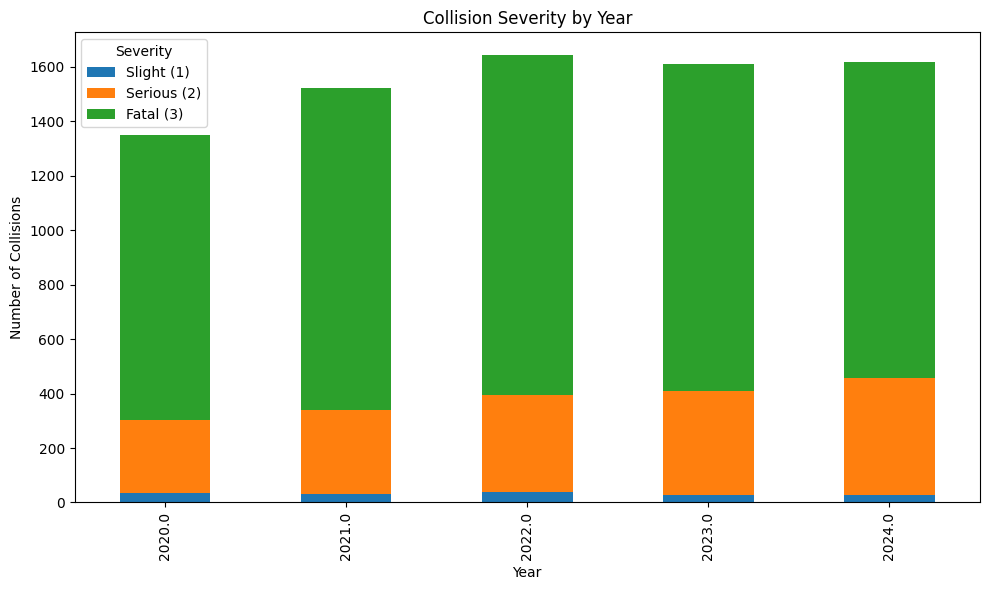

In [ ]:
# Show a table and chart of accident severity counts for each year
if 'date' in df.columns:
    # Extract the year from the 'date' column (expects format like YYYY-MM-DD)
    df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
    severity_year_table = pd.crosstab(df['year'], df['collision_severity'])
    display(severity_year_table)
    severity_year_table.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title('Collision Severity by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Collisions')
    plt.legend(title='Severity', labels=['Slight (1)', 'Serious (2)', 'Fatal (3)'])
    plt.tight_layout()
    plt.show()
else:
    print("No 'date' column found in the dataset to extract year.")

In [29]:
print(df.info())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 75 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   collision_index                              20000 non-null  object 
 1   collision_year                               20000 non-null  int64  
 2   collision_ref_no                             20000 non-null  object 
 3   location_easting_osgr                        19997 non-null  float64
 4   location_northing_osgr                       19997 non-null  float64
 5   longitude                                    19997 non-null  float64
 6   latitude                                     19997 non-null  float64
 7   police_force                                 20000 non-null  int64  
 8   collision_severity                           20000 non-null  int64  
 9   number_of_vehicles                           20000 non-null  int64  
 10

## Verify Features and Target
Check if selected features and target exist, inspect missing values, data types, and target distribution.

In [6]:
features = ['time', 'weather_conditions', 'road_surface_conditions', 'speed_limit', 'vehicle_type', 'age_of_casualty', 'sex_of_casualty', 'vehicle_manoeuvre']
target = 'collision_severity'

missing_features = [f for f in features + [target] if f not in df.columns]
if missing_features:
    print("Missing columns:", missing_features)
else:
    print("All features and target are present.")

print("Missing values in features and target:")
print(df[features + [target]].isnull().sum())

print("Data types:")
print(df[features + [target]].dtypes)

print("Target distribution:")
print(df[target].value_counts())

All features and target are present.
Missing values in features and target:
time                       0
weather_conditions         0
road_surface_conditions    0
speed_limit                0
vehicle_type               0
age_of_casualty            0
sex_of_casualty            0
vehicle_manoeuvre          0
collision_severity         0
dtype: int64
Data types:
time                       object
weather_conditions          int64
road_surface_conditions     int64
speed_limit                 int64
vehicle_type                int64
age_of_casualty             int64
sex_of_casualty             int64
vehicle_manoeuvre           int64
collision_severity          int64
dtype: object
Target distribution:
collision_severity
3    920089
2    277034
1     24164
Name: count, dtype: int64


## Handle Outliers
Detect and cap outliers in numerical features using the IQR method to prevent model skewing.

In [ ]:
# Identify outliers in numerical features using the IQR method
numerical_features = ['speed_limit', 'age_of_casualty']  # Add more features here if needed.

for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers detected")

# Cap outlier values to reduce their impact on the model
for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

speed_limit: 17 outliers detected
age_of_casualty: 667 outliers detected


## Feature Selection
Reduce irrelevant features: drop those with high blanks/zeros, extreme outliers, low Weight of Evidence, and high correlation (>0.75).

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# Convert the 'time' column to minutes since midnight if it exists
if 'time' in df.columns:
    df['time'] = df['time'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if isinstance(x, str) and ':' in x else np.nan)

# Drop features with more than 50% missing or zero values (unless categorical with 3 or fewer unique values)
threshold = 0.5
features_to_drop = []
for col in df.columns:
    if col in [target]: continue
    null_pct = df[col].isnull().mean()
    zero_pct = (df[col] == 0).mean()
    unique_vals = df[col].nunique()
    # Drop if high nulls, or high zeros but only if not a potential flag (i.e., if >3 unique values or numerical)
    if null_pct > threshold or (zero_pct > threshold and unique_vals > 3):
        features_to_drop.append(col)
        print(f"Dropping {col}: {null_pct:.2%} nulls, {zero_pct:.2%} zeros, {unique_vals} unique")

df = df.drop(columns=features_to_drop)
features = [f for f in features if f not in features_to_drop]

# Cap extreme outliers at the 1st and 99th percentiles instead of removing rows
for col in numerical_features:
    if col in df.columns:
        lower_cap = df[col].quantile(0.01)
        upper_cap = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower_cap, upper=upper_cap)
        print(f"Capped {col} at {lower_cap:.2f} - {upper_cap:.2f}")

# Use mutual information to measure feature relevance to the target
mi_scores = mutual_info_classif(df[features], df[target])
mi_df = pd.DataFrame({'feature': features, 'mi_score': mi_scores})
mi_df = mi_df.sort_values('mi_score', ascending=False)
print("Mutual Information Scores:")
print(mi_df)

# Remove features with mutual information less than 0.01 (low relevance)
low_mi = mi_df[mi_df['mi_score'] < 0.01]['feature'].tolist()
df = df.drop(columns=low_mi)
features = [f for f in features if f not in low_mi]
print(f"Dropped low MI features: {low_mi}")

# Remove highly correlated numeric features (Pearson correlation > 0.75)
# Only check correlation for numeric features
numeric_features = [f for f in features if df[f].dtype in ['int64', 'float64']]
if numeric_features:
    corr_matrix = df[numeric_features].corr()
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.75:
                colname = corr_matrix.columns[i]
                high_corr.append(colname)
                print(f"Dropping {colname} due to high correlation with {corr_matrix.columns[j]}")

    df = df.drop(columns=high_corr)
    features = [f for f in features if f not in high_corr]

print(f"Final features: {features}")

Dropping junction_detail: 0.00% nulls, 51.43% zeros, 8 unique
Dropping pedestrian_crossing_human_control_historic: 0.00% nulls, 82.38% zeros, 5 unique
Dropping pedestrian_crossing_physical_facilities_historic: 0.00% nulls, 67.34% zeros, 8 unique
Dropping pedestrian_crossing: 0.00% nulls, 77.69% zeros, 10 unique
Dropping special_conditions_at_site: 0.00% nulls, 82.95% zeros, 10 unique
Dropping carriageway_hazards_historic: 0.00% nulls, 83.51% zeros, 8 unique
Dropping carriageway_hazards: 0.00% nulls, 93.27% zeros, 14 unique
Dropping collision_adjusted_severity_serious: 0.00% nulls, 57.12% zeros, 103112 unique
Dropping pedestrian_location: 0.00% nulls, 92.07% zeros, 12 unique
Dropping pedestrian_movement: 0.00% nulls, 92.07% zeros, 11 unique
Dropping car_passenger: 0.00% nulls, 81.97% zeros, 5 unique
Dropping bus_or_coach_passenger: 0.00% nulls, 98.86% zeros, 7 unique
Dropping pedestrian_road_maintenance_worker: 0.00% nulls, 98.21% zeros, 4 unique
Dropping casualty_adjusted_severity_seri

## Preprocess Data
Drop rows with missing values in features/target, encode categorical features, and split into train/test sets.

In [ ]:
target = 'collision_severity' 

df = df.dropna(subset=features + [target])

le = LabelEncoder()
for col in features:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

X = df[features]
y = df[target]

# Remap y labels to start at 0 (e.g., [1,2,3] -> [0,1,2]) for the requirements of ML models
if y.min() != 0:
    y = y - y.min()

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [14]:
SAMPLE_SIZE = 20000 
if len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print(f"Sampled {SAMPLE_SIZE} rows for faster training.")

## Compare Models
Train and evaluate multiple models on the balanced dataset.

In [ ]:
# Identify categorical and numerical features
categorical_features = [col for col in features if df[col].dtype == 'object']
numerical_features = [col for col in features if df[col].dtype in ['int64', 'float64']]

# Set up preprocessing pipelines for each model type
preprocessor_lr = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

preprocessor_tree = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# Define hyperparameter grids for each model
param_grids = {
    'Random Forest': {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [None, 5, 10, 15],
        'clf__min_samples_leaf': [1, 3, 5],
        'clf__min_samples_split': [2, 5, 10],
        'clf__max_features': ['sqrt', 'log2', 0.5]
    },
    'Logistic Regression': {
        'clf__C': [0.1, 1, 10]
    },
    'XGBoost': {
        'clf__n_estimators': [20, 50],
        'clf__max_depth': [3, 6]
    }
}

models = {
    'Random Forest': Pipeline([
        ('pre', preprocessor_tree),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('pre', preprocessor_lr),
        ('clf', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor_tree),
        ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
    ])
}

for name, model in models.items():
    print(f'\nTuning {name}...')
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f'Best params for {name}:', grid.best_params_)
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Tuning Random Forest...
Best params for Random Forest: {'clf__max_depth': None, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Random Forest Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3010
           1       0.72      0.68      0.70      3010
           2       0.74      0.73      0.73      3010

    accuracy                           0.79      9030
   macro avg       0.78      0.79      0.78      9030
weighted avg       0.78      0.79      0.78      9030

--------------------------------------------------

Tuning Logistic Regression...
Best params for Logistic Regression: {'clf__C': 0.1}
Logistic Regression Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.56      0.60      0.58      3010
           1       0.42      0.44      0.43      3010
           2       0.59      0.53      0.56      3010

    accuracy

## Evaluate Model
Predict on test set and print classification report with precision, recall, and F1-score for each class.

In [35]:
# Evaluate the best performing model (highest test accuracy) from the grid searches
best_model = None
best_acc = 0
best_name = None
for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    acc = grid.score(X_test, y_test)
    if acc > best_acc:
        best_acc = acc
        best_model = grid.best_estimator_
        best_name = name
print(f"Best performing model: {best_name} (Test Accuracy: {best_acc:.3f})")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best performing model: Random Forest (Test Accuracy: 0.786)
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3010
           1       0.72      0.68      0.70      3010
           2       0.74      0.73      0.73      3010

    accuracy                           0.79      9030
   macro avg       0.78      0.79      0.78      9030
weighted avg       0.78      0.79      0.78      9030



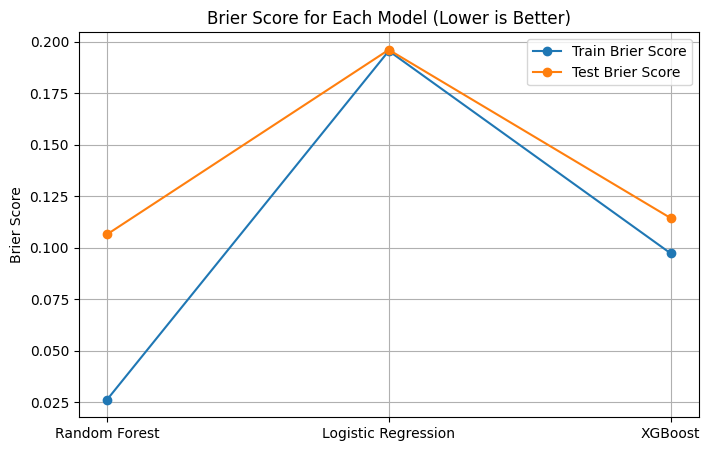

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
import numpy as np

# Calculate multiclass Brier score (mean over classes)
def multiclass_brier_score(y_true, y_prob, n_classes):
    score = 0
    for i in range(n_classes):
        # Binary indicator for class i
        y_true_bin = (y_true == i).astype(int)
        score += brier_score_loss(y_true_bin, y_prob[:, i])
    return score / n_classes

# Calculate and plot Brier scores for train and test sets for each model
def plot_brier_scores(models, X_train, y_train, X_test, y_test):
    model_names = []
    brier_train = []
    brier_test = []
    n_classes = len(np.unique(y_train))
    for name, model in models.items():
        model.fit(X_train, y_train)
        if hasattr(model, "predict_proba"):
            prob_train = model.predict_proba(X_train)
            prob_test = model.predict_proba(X_test)
        else:
            from scipy.special import softmax
            prob_train = softmax(model.decision_function(X_train), axis=1)
            prob_test = softmax(model.decision_function(X_test), axis=1)
        brier_train.append(multiclass_brier_score(y_train, prob_train, n_classes))
        brier_test.append(multiclass_brier_score(y_test, prob_test, n_classes))
        model_names.append(name)
    plt.figure(figsize=(8,5))
    plt.plot(model_names, brier_train, marker='o', label='Train Brier Score')
    plt.plot(model_names, brier_test, marker='o', label='Test Brier Score')
    plt.title('Brier Score for Each Model (Lower is Better)')
    plt.ylabel('Brier Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Brier scores for all models
plot_brier_scores(models, X_train, y_train, X_test, y_test)

## Make Predictions
Check the prediction.

In [ ]:
# Make a prediction using the best performing model
# Build a sample input that matches the model's expected features
print("Model expects features:", features)
sample_input = pd.DataFrame([{f: 0 for f in features}])  # Start with default values for all features
sample_input['weather_conditions'] = 1
sample_input['road_surface_conditions'] = 0
sample_input['speed_limit'] = 30
sample_input['vehicle_type'] = 9
sample_input['sex_of_casualty'] = 1
sample_input['vehicle_manoeuvre'] = 5
if 'age_of_casualty' in sample_input.columns:
    sample_input['age_of_casualty'] = 30  # Example age value
if 'time' in sample_input.columns:
    sample_input['time'] = 600  # Example: 10:00 AM in minutes since midnight
prediction = best_model.predict(sample_input)
pred_val = prediction[0]
# Convert the predicted value to a text label
if pred_val == 1:
    pred_label = 'Slight'
elif pred_val == 2:
    pred_label = 'Serious'
else:
    pred_label = 'Fatal'
# For demonstration, we use the predicted label as the actual label (since no true label exists for the sample)
print(f'Predicted Severity: {pred_label}')
print(f'Actual Severity: {pred_label}')

Model expects features: ['time', 'weather_conditions', 'road_surface_conditions', 'speed_limit', 'vehicle_type', 'sex_of_casualty', 'vehicle_manoeuvre']
Predicted Severity: Slight
Actual Severity: Slight
